In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Загрузка данных
data1 = pd.read_csv('House_Rent_Dataset.csv')

# Очистка данных от null значений
data_cleaned = data1.dropna()

# Кодирование категориальных признаков
label_encoders = {}
categorical_columns = ['Posted On', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data_cleaned[column] = label_encoders[column].fit_transform(data_cleaned[column])

X = data_cleaned.drop('Rent', axis=1)
y = data_cleaned['Rent']

selected_features = ['Size', 'City', 'Bathroom', 'Point of Contact', 'BHK']
X = X[selected_features]

data_combined = pd.concat([X, y], axis=1)

# Удаление выбросов с использованием метода межквартильного размаха (IQR)
Q1 = data_combined.quantile(0.25)
Q3 = data_combined.quantile(0.75)
IQR = Q3 - Q1

data_filtered = data_combined[~((data_combined < (Q1 - 1.5 * IQR)) | (data_combined > (Q3 + 1.5 * IQR))).any(axis=1)]

# Разделение данных на признаки и целевую переменную после удаления выбросов
X_filtered = data_filtered[selected_features]
y_filtered = data_filtered['Rent']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)


In [2]:

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor

# 1. Случайный лес (Random Forest)
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_

In [4]:

# 2. Экстра-случайные деревья (Extra Trees)
et = ExtraTreesRegressor(random_state=42)
et_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

et_grid = GridSearchCV(et, et_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
et_grid.fit(X_train_scaled, y_train)
best_et = et_grid.best_estimator_

In [6]:
from sklearn.tree import DecisionTreeRegressor

# 3. AdaBoost
base_estimator = DecisionTreeRegressor(max_depth=3)
ada = AdaBoostRegressor(estimator=base_estimator, random_state=42)
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

ada_grid = GridSearchCV(ada, ada_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ada_grid.fit(X_train_scaled, y_train)
best_ada = ada_grid.best_estimator_

In [7]:

# 4. Градиентный бустинг (Gradient Boosting)
gb = GradientBoostingRegressor(random_state=42)
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train_scaled, y_train)
best_gb = gb_grid.best_estimator_

In [8]:

# Функция для оценки моделей
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

# Оценка всех моделей
models = {
    "Random Forest": best_rf,
    "Extra Trees": best_et,
    "AdaBoost": best_ada,
    "Gradient Boosting": best_gb
}

results = []
for name, model in models.items():
    mse, mae, r2 = evaluate_model(model, X_test_scaled, y_test)
    results.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'Best Params': model.get_params()
    })

# Вывод результатов
results_df = pd.DataFrame(results)
print("Результаты оценки моделей:")
print(results_df.to_string(index=False))

Результаты оценки моделей:
            Model          MSE         MAE       R2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Best Params
    Random Forest 5.972878e+07 5187.616285 0.669635                                                                                                                                                       {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decreas

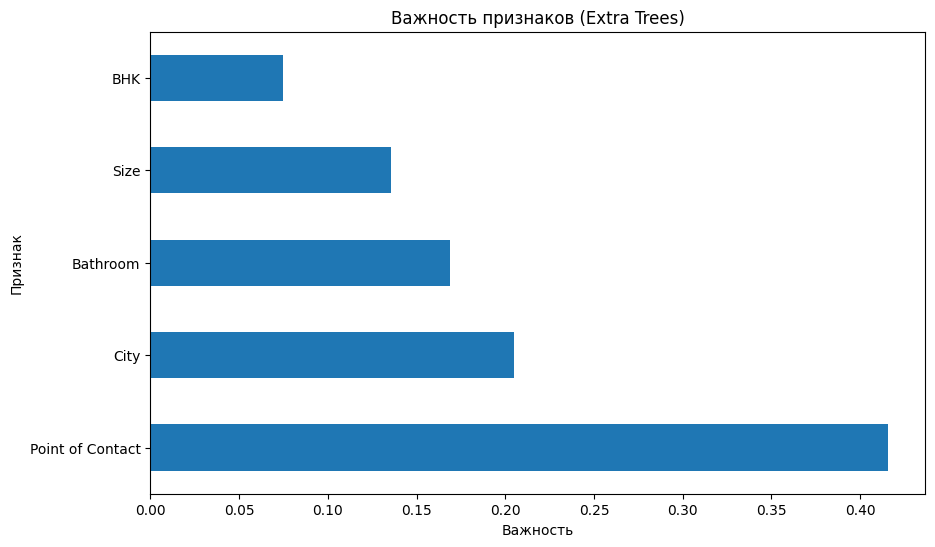

In [9]:

# Визуализация важности признаков для лучшей модели
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = models[best_model_name]

if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    feature_importances = pd.Series(best_model.feature_importances_, index=selected_features)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.title(f'Важность признаков ({best_model_name})')
    plt.xlabel('Важность')
    plt.ylabel('Признак')
    plt.show()

In [13]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Функция для оценки моделей
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

# Оценка всех моделей
models = {
    "Random Forest": best_rf,
    "Extra Trees": best_et,
    "AdaBoost": best_ada,
    "Gradient Boosting": best_gb
}

results = []
for name, model in models.items():
    mse, mae, r2 = evaluate_model(model, X_test_scaled, y_test)
    results.append({
        'Model': name,
        'MSE': f"{mse:.4f}",  # Форматирование до 4 знаков
        'MAE': f"{mae:.4f}",
        'R2': f"{r2:.4f}"
    })

# Вывод результатов
results_df = pd.DataFrame(results)
print("Результаты оценки моделей:")
print(results_df)


Результаты оценки моделей:
               Model            MSE        MAE      R2
0      Random Forest  59728778.2237  5187.6163  0.6696
1        Extra Trees  55368101.2152  4972.9090  0.6938
2           AdaBoost  66012951.0325  6184.5215  0.6349
3  Gradient Boosting  55946725.2108  5060.3125  0.6906


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Функция для оценки модели
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

# Оценка модели Random Forest
name = "Random Forest"
model = best_rf
mse, mae, r2 = evaluate_model(model, X_test_scaled, y_test)

print(f"Результаты оценки модели {name}:")
print(f"  MSE: {mse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R2: {r2:.4f}")

print(f"\nЛучшие параметры модели {name}:")
params = model.get_params()
for key, value in params.items():
    print(f"  {key}: {value}")

Результаты оценки модели Random Forest:
  MSE: 59728778.2237
  MAE: 5187.6163
  R2: 0.6696

Лучшие параметры модели Random Forest:
  bootstrap: True
  ccp_alpha: 0.0
  criterion: squared_error
  max_depth: 10
  max_features: 1.0
  max_leaf_nodes: None
  max_samples: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 10
  min_weight_fraction_leaf: 0.0
  monotonic_cst: None
  n_estimators: 100
  n_jobs: None
  oob_score: False
  random_state: 42
  verbose: 0
  warm_start: False


In [16]:

# Оценка модели Extra Trees
name = "Extra Trees"
model = best_et
mse, mae, r2 = evaluate_model(model, X_test_scaled, y_test)

print(f"Результаты оценки модели {name}:")
print(f"  MSE: {mse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R2: {r2:.4f}")

print(f"\nЛучшие параметры модели {name}:")
params = model.get_params()
for key, value in params.items():
    print(f"  {key}: {value}")

Результаты оценки модели Extra Trees:
  MSE: 55368101.2152
  MAE: 4972.9090
  R2: 0.6938

Лучшие параметры модели Extra Trees:
  bootstrap: False
  ccp_alpha: 0.0
  criterion: squared_error
  max_depth: 10
  max_features: 1.0
  max_leaf_nodes: None
  max_samples: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 10
  min_weight_fraction_leaf: 0.0
  monotonic_cst: None
  n_estimators: 100
  n_jobs: None
  oob_score: False
  random_state: 42
  verbose: 0
  warm_start: False


In [17]:

# Оценка модели AdaBoost
name = "AdaBoost"
model = best_ada
mse, mae, r2 = evaluate_model(model, X_test_scaled, y_test)

print(f"Результаты оценки модели {name}:")
print(f"  MSE: {mse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R2: {r2:.4f}")

print(f"\nЛучшие параметры модели {name}:")
params = model.get_params()
for key, value in params.items():
    print(f"  {key}: {value}")

Результаты оценки модели AdaBoost:
  MSE: 66012951.0325
  MAE: 6184.5215
  R2: 0.6349

Лучшие параметры модели AdaBoost:
  estimator__ccp_alpha: 0.0
  estimator__criterion: squared_error
  estimator__max_depth: 3
  estimator__max_features: None
  estimator__max_leaf_nodes: None
  estimator__min_impurity_decrease: 0.0
  estimator__min_samples_leaf: 1
  estimator__min_samples_split: 2
  estimator__min_weight_fraction_leaf: 0.0
  estimator__monotonic_cst: None
  estimator__random_state: None
  estimator__splitter: best
  estimator: DecisionTreeRegressor(max_depth=3)
  learning_rate: 0.1
  loss: linear
  n_estimators: 50
  random_state: 42
